This reads in implementation data and looks at time to implement protocols relative to ORCA and other implementation barrier data.

In [1]:
import pandas as pd
import os
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from datetime import datetime
import yaml
%matplotlib inline

In [36]:
conf = 'default'
with open("config.yml", "r") as stream:
    try:
       cnf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [16]:
in_file = os.path.join(os.getcwd(),cnf[conf]['data_path'], cnf['default']['data_file'])

sheets_to_read = [
    'C3, C3B, C4 all data'
    #'Clean check ins +Colo ORCA',
    #'Clean C2-Barriers Questions'
]

'''date_cols = {
    'C2_CT1_Q3':'First_ERAS_pt_Colo_T1',
    'C2_CT1_Q5':'Updated_protocol_Colo_T1',
    'C2_CT2_Q3':'First_ERAS_pt_Colo_T2',
    'C2_CT2_Q4':'Updated_protocol_Colo_T2',
    #'C2_HFT2_Q3':'',
    #'C2_HFT2_Q5':'',
    'C2_CT3_Q3':'First_ERAS_pt_Colo_T3',
    'C2_CT3_Q5':'Updated_protocol_Colo_T3'
}

# cohort dates...
end = pd.to_datetime('09/30/2019')
start = pd.to_datetime('03/01/2018')'''
df = pd.read_excel(in_file,sheets_to_read[0],header=0,index_col=None)
print(len(df))

227


In [17]:
# uses only those who didn't withdraw from the program
cohort_cols = [
    'C3_C',
    'WD_C3_C',
    'C3_O',
    'WD_C3_O',
    'C3_G',
    'WD_C3_G',
    'C3B_C',
    'WD_C3B_C',
    'C3B_O',
    'WD_C3B_O',
    'C3B_G',
    'WD_C3B_G'
]

df[cohort_cols] = df[cohort_cols].astype('bool')

mask = (
    ((df.C3_C == True) & (df.WD_C3_C == False)) |
    ((df.C3_O == True) & (df.WD_C3_O == False)) |
    ((df.C3_G == True) & (df.WD_C3_G == False)) |
    ((df.C3B_C == True) & (df.WD_C3B_C == False)) |
    ((df.C3B_O == True) & (df.WD_C3B_O == False)) |
    ((df.C3B_G == True) & (df.WD_C3B_G == False))
)

print(len(df))
df = df.loc[mask]
print(len(df))

227
140


In [13]:
def recode_date(x):
    
    if isinstance(x, str) and (len(x.split('_')) == 3):
        return datetime.strptime(x, '%m_%d_%Y')
    else: 
        return pd.NaT

for col in list(date_cols.keys()):
    df[date_cols[col]] = df[col].apply(lambda x: recode_date(x))

KeyError: 'C2_CT1_Q3'

In [4]:
df['event'] = 0
New_protocol_dates = ['First_ERAS_pt_Colo_T1','First_ERAS_pt_Colo_T2','First_ERAS_pt_Colo_T3']
Updated_protocol_dates = ['Updated_protocol_Colo_T1','Updated_protocol_Colo_T2','Updated_protocol_Colo_T3']
df['date'] = df[New_protocol_dates].max(axis=1)
df.loc[~pd.isna(df.date),'event'] = 1
df.loc[pd.isna(df.date),'date'] = end
df['days'] = (df.date - start).dt.days
# for teams that had a protocol in place already, replaces with 'udpdated' dates
use_updated = False
if use_updated:
    df.loc[df.days<=0,'date'] = df.loc[df.days<=0,Updated_protocol_dates].max(axis=1)
    df.loc[df.days<=0,'days'] = (df.loc[df.days<=0,'date'] - start).dt.days
truncate = True
if truncate:
    df.loc[df.days<=0,'days'] = 0 
#df.event = df.date.apply(lambda x: x != pd.NaT)
#df.head()

In [306]:
#df_barriers = pd.read_excel(in_file,sheets_to_read[1],header=0,index_col=None)
'''barrierCols = {
    'Q56_1_C2_CT1':'Insufficient knowledge of evidence supporting interventions',
    'Q56_2_C2_CT1':'Not enough leadership support from EXECUTIVES',
    'Q56_3_C2_CT1':'Not enough leadership support from SURGEONS',
    'Q56_4_C2_CT1':' Not enough leadership support from ANESTHESIOLOGISTS',
    'Q56_5_C2_CT1':'Not enough leadership support from NURSES',
    'Q56_6_C2_CT1':'Insufficient autonomy/authority',
    'Q56_7_C2_CT1':'Lack of quality improvement skills',
    'Q56_8_C2_CT1':'Confusion about how to proceed with enhanced surgical care and recovery activities',
    'Q56_9_C2_CT1':'Lack of team member consensus regarding goals',
    'Q56_10_C2_CT1':'Inability of team members to work together',
    'Q56_11_C2_CT1':'Not enough buy-in from SURGERY staff',
    'Q56_12_C2_CT1':'Not enough buy-in from ANESTHESIOLOGY staff',
    'Q56_13_C2_CT1':'Not enough buy-in from NURSING staff',
    'Q56_14_C2_CT1':'Not enough buy-in from OTHER staff',
    'Q56_15_C2_CT1':'Not enough time',
    'Q56_16_C2_CT1':'Staff turnover on unit',
    'Q56_17_C2_CT1':'Data collection burden for staff',
    'Q56_18_C2_CT1':'Problems with data systems',
    'Q56_19_C2_CT1':'Competing priorities or distractions (e.g. new EMR, accreditation visit)'
}'''
#cols = list(barrierCols.keys()) + ['Hospital Name','Hospital ID']
#df_barriers = df_barriers[cols]
#df_barriers.head()

"barrierCols = {\n    'Q56_1_C2_CT1':'Insufficient knowledge of evidence supporting interventions',\n    'Q56_2_C2_CT1':'Not enough leadership support from EXECUTIVES',\n    'Q56_3_C2_CT1':'Not enough leadership support from SURGEONS',\n    'Q56_4_C2_CT1':' Not enough leadership support from ANESTHESIOLOGISTS',\n    'Q56_5_C2_CT1':'Not enough leadership support from NURSES',\n    'Q56_6_C2_CT1':'Insufficient autonomy/authority',\n    'Q56_7_C2_CT1':'Lack of quality improvement skills',\n    'Q56_8_C2_CT1':'Confusion about how to proceed with enhanced surgical care and recovery activities',\n    'Q56_9_C2_CT1':'Lack of team member consensus regarding goals',\n    'Q56_10_C2_CT1':'Inability of team members to work together',\n    'Q56_11_C2_CT1':'Not enough buy-in from SURGERY staff',\n    'Q56_12_C2_CT1':'Not enough buy-in from ANESTHESIOLOGY staff',\n    'Q56_13_C2_CT1':'Not enough buy-in from NURSING staff',\n    'Q56_14_C2_CT1':'Not enough buy-in from OTHER staff',\n    'Q56_15_C2_CT

In [22]:
#df_barriers = pd.read_excel(in_file,sheets_to_read[1],header=0,index_col=None)

# Generates items for each administration of survey
item_dict = {
    'C':67,
    'O':68,
    'G':69,
}
barrier_items = []

for cohort in ['C3','C3B']:
    for service_line in ['C','O','G']:
        for admin in range(1,4):
            if (cohort == 'C3B') & (admin == 2):
                pass # barrier items were not asked for this time for 3B
            elif (cohort == 'C3') & (admin == 1):
                new_items = ['Q{}_{}_{}_{}T{}'.format(str(item_dict[service_line]+1), str(i), cohort, service_line,str(admin)) for i in range(1,20)]
                if len(barrier_items) == 0:
                    barrier_items = new_items
                else:
                    barrier_items = barrier_items + new_items
            else:
                new_items = ['Q{}_{}_{}_{}T{}'.format(str(item_dict[service_line]), str(i), cohort, service_line,str(admin)) for i in range(1,20)]
                if len(barrier_items) == 0:
                    barrier_items = new_items
                else:
                    barrier_items = barrier_items + new_items
            

# Creates and saves summary file for barriers
cols = barrier_items.copy()
cols.append('Hospital Name')
df_barriers = df[cols].copy()

barriers_long = pd.melt(df_barriers, id_vars='Hospital Name',value_vars=barrier_items,var_name='item_code',value_name='barrier_score')
barriers_long.dropna(how='all', axis = 0,subset = ['barrier_score'],inplace=True)
barriers_long['item'] = barriers_long['item_code'].apply(lambda x: x.split('_')[1])
barriers_long['cohort'] = barriers_long['item_code'].apply(lambda x: x.split('_')[-1][0])
barriers_long['administration'] = barriers_long['item_code'].apply(lambda x: x.split('_')[-1][2])
barriers_long['barrier_score'] = barriers_long['barrier_score'].astype('Int64')
barriers_long['barrier_score'] =  barriers_long['barrier_score'] > 2
barriers_long['barrier_score'] = barriers_long['barrier_score'].astype(int)
barriers_long.head()
x = barriers_long.groupby(['item','administration'], as_index=False)['barrier_score'].mean()
#x.to_csv('Barrier_score_ITEM_by_Time.csv')
x.to_csv(os.path.join(os.getcwd(), cnf[conf]['output_path'],cnf[conf]['barrier_score_ITEM_by_time']))

In [23]:
barrier_cat_recode = {
    1:'Knowledge',
    2:'Leadership support',
    3:'Leadership support',
    4:'Leadership support',
    5:'Leadership support',
    6:'Leadership support',
    7:'Team skills and cohesion',
    8:'Team skills and cohesion',
    9:'Team skills and cohesion',
    10:'Team skills and cohesion',
    11:'Pushback',
    12:'Pushback',
    13:'Pushback',
    14:'Pushback',
    15:'Workload',
    16:'Workload',
    17:'Workload',
    18:'Workload',
    19:'Workload'
}
barriers_long['Barrier_cat'] = barriers_long['item'].copy()
barriers_long['Barrier_cat'] = barriers_long['Barrier_cat'].astype('int')
barriers_long['Barrier_cat'].replace(to_replace=barrier_cat_recode,value=None,inplace=True)
barriers_long.head()

y = barriers_long.groupby(['Barrier_cat','administration'], as_index=False)['barrier_score'].mean()
#y.to_csv('Barrier_score_by_CATEGORY_by_Time.csv')
y.to_csv(os.path.join(os.getcwd(), cnf[conf]['output_path'],cnf[conf]['barrier_score_by_CATEGORY_by_time']))

z = barriers_long.merge(barriers_long.groupby(['Hospital Name','Barrier_cat'])['barrier_score'].any().rename('Barrier_Tif1T').to_frame().reset_index())
z = barriers_long.groupby(['Hospital Name','cohort','administration','Barrier_cat'], as_index=False)['barrier_score'].any()
zz = z.groupby(['administration','Barrier_cat'], as_index = False).mean()
zz.to_csv('Barrier_score_by_CATEGORY_by_Time_2.csv')

In [46]:
HQI_process_items = {
    'Q51_C3_T1':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q50_C3_T2':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q50_C3_T3':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    
    'Q50_C3B_T1':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q50_C3B_T2':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q50_C3B_T3':'How often do you share reports of your process measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?'
}

HQI_outcome_items = {

    'Q53_C3_T1':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q52_C3_T2':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q52_C3_T3':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    
    'Q51_C3B_T1':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q51_C3B_T2':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?',
    'Q52_C3B_T3':'How often do you share reports of your outcome measures with frontline providers (bedside nurses, surgeons, anesthesia providers, physical therapy, etc.)?'
}

HQI_leadership_items = {
    'Q59_C3_T1':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?',
    'Q58_C3_T2':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?',
    'Q58_C3_T3':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?',
    
    'Q58_C3B_T1':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?',
    'Q58_C3B_T2':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?',
    'Q58_C3B_T3':'How often does your Senior Executive sponsor (or someone from his/her office) attend the ISCR team meetings?'
}

HQI_team_items = {
    'Q56_C3_CT1':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    'Q55_C3_CT2':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    'Q55_C3_CT3':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    
    'Q55_C3B_CT1':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    'Q55_C3B_CT2':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    'Q55_C3B_CT3':'At this point in time, how often does your COLORECTAL ISCR team meet?',
    
    'Q57_C3_OT1':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    'Q56_C3_OT2':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    'Q56_C3_OT3':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    
    'Q56_C3B_OT1':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    'Q56_C3B_OT2':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    'Q56_C3B_OT3':'At this point in time, how often does your ORTHOPEDIC ISCR team meet?',
    
    'Q58_C3_GT1':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?',
    'Q57_C3_GT2':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?',
    'Q57_C3_GT3':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?',
    
    'Q57_C3B_GT1':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?',
    'Q57_C3B_GT2':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?',
    'Q57_C3B_GT3':'At this point in time, how often does your GYNECOLOGIC ISCR team meet?'
}

In [47]:
HQI_cols = list(HQI_outcome_items.keys())
HQI_df = df[HQI_cols + ['Hospital Name']].copy()
HQI_long = pd.melt(HQI_df, id_vars='Hospital Name', value_vars = HQI_cols, var_name = 'outcome_item', value_name = 'outcome_score')
HQI_long.dropna(how='all', axis = 0,subset = ['outcome_score'],inplace=True)
HQI_long['administration'] = HQI_long['outcome_item'].apply(lambda x: x.split('_')[2][-1])
HQI_long['outcome_score'] = HQI_long['outcome_score'].astype('Int64')
HQI_long['outcome_score'] = HQI_long['outcome_score'] < 3

HQI_long_sum = HQI_long.copy()
#print(len(HQI_long_sum))

HQI_cols = list(HQI_process_items.keys())
HQI_df = df[HQI_cols + ['Hospital Name']].copy()
HQI_long = pd.melt(HQI_df, id_vars='Hospital Name', value_vars = HQI_cols, var_name = 'process_item', value_name = 'process_score')
HQI_long.dropna(how='all', axis = 0,subset = ['process_score'],inplace=True)
HQI_long['administration'] = HQI_long['process_item'].apply(lambda x: x.split('_')[2][-1])
HQI_long['process_score'] = HQI_long['process_score'].astype('Int64')
HQI_long['process_score'] = HQI_long['process_score'] < 3

HQI_long_sum = HQI_long_sum.merge(HQI_long,on=['Hospital Name', 'administration'], how = 'outer')

HQI_cols = list(HQI_leadership_items.keys())
HQI_df = df[HQI_cols + ['Hospital Name']].copy()
HQI_long = pd.melt(HQI_df, id_vars='Hospital Name', value_vars = HQI_cols, var_name = 'leadership_item', value_name = 'leadership_score')
HQI_long.dropna(how='all', axis = 0,subset = ['leadership_score'],inplace=True)
HQI_long['administration'] = HQI_long['leadership_item'].apply(lambda x: x.split('_')[2][-1])
HQI_long['leadership_score'] = HQI_long['leadership_score'].astype('Int64')
HQI_long['leadership_score_bool'] = False
mask = (HQI_long['administration'] != 3) & (HQI_long['leadership_score'] < 3)
HQI_long.loc[mask,'leadership_score_bool'] = True
mask = (HQI_long['administration'] == 3) & (HQI_long['leadership_score'] < 4) # becomes more lenient on last administration (requires less executive engagement)
HQI_long.loc[mask,'leadership_score_bool'] = True
HQI_long['leadership_score'] = HQI_long['leadership_score_bool']
HQI_long.drop(columns = 'leadership_score_bool',inplace=True)
#HQI_long['leadership_score'] = HQI_long['leadership_score'] < 4

HQI_long_sum = HQI_long_sum.merge(HQI_long,on=['Hospital Name', 'administration'], how = 'outer')

HQI_cols = list(HQI_team_items.keys())
HQI_df = df[HQI_cols + ['Hospital Name']].copy()
HQI_long = pd.melt(HQI_df, id_vars='Hospital Name', value_vars = HQI_cols, var_name = 'team_item', value_name = 'team_score')
HQI_long.dropna(how='all', axis = 0,subset = ['team_score'],inplace=True)
HQI_long['administration'] = HQI_long['team_item'].apply(lambda x: x.split('_')[2][-1])
HQI_long['team_score'] = HQI_long['team_score'].astype('Int64')
HQI_long['team_score'] = HQI_long['team_score'] < 4

HQI_long_sum = HQI_long_sum.merge(HQI_long,on=['Hospital Name', 'administration'], how = 'outer')

HQI_long_sum.head()

,Hospital Name,outcome_item,outcome_score,administration,process_item,process_score,leadership_item,leadership_score,team_item,team_score
0,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q56_C3_CT1,True
1,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q57_C3_OT1,True
2,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q58_C3_GT1,True
3,Atrium Health Cleveland,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q56_C3_CT1,False
4,Atrium Health Cleveland,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q57_C3_OT1,False


In [54]:
len(HQI_long_sum)
len(HQI_long_sum.dropna(axis = 'index', how = 'any', subset = HQI_cols))

560

In [55]:
def quality_implementation_recode(row):
    HQI_cols = ['outcome_score','process_score','leadership_score','team_score']

    if row[HQI_cols].all(): return 'High'
    elif (row[['outcome_score','process_score']].any() & row[['leadership_score','team_score']].any()): return 'Moderate'
    elif (row[['outcome_score','process_score']].any() | row[['leadership_score','team_score']].any()): return 'Marginal'
    else: return 'Low'
HQI_cols = ['outcome_score','process_score','leadership_score','team_score']
HQI_long_sum['HQI_Tot'] = HQI_long_sum[HQI_cols].all(axis='columns')
HQI_long_sum = HQI_long_sum.dropna(axis = 'index', how = 'any', subset = HQI_cols)
test = HQI_long_sum.groupby(['Hospital Name', 'administration'], as_index=False)[['outcome_score','process_score','leadership_score','team_score']].all()
HQI_long_sum['Implementation_quality'] = HQI_long_sum[['outcome_score','process_score','leadership_score','team_score']].apply(lambda x: quality_implementation_recode(x),axis=1)
HQI_long_sum.head(20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Hospital Name,outcome_item,outcome_score,administration,process_item,process_score,leadership_item,leadership_score,team_item,team_score,HQI_Tot,Implementation_quality
0,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q56_C3_CT1,True,False,Marginal
1,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q57_C3_OT1,True,False,Marginal
2,AMITA Health Saint Joseph Hospital Chicago,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q58_C3_GT1,True,False,Marginal
3,Atrium Health Cleveland,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q56_C3_CT1,False,False,Low
4,Atrium Health Cleveland,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q57_C3_OT1,False,False,Low
5,Augusta University Medical Center,Q53_C3_T1,True,1,Q51_C3_T1,True,Q59_C3_T1,False,Q56_C3_CT1,True,False,Moderate
7,Beebe Healthcare,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q58_C3_GT1,False,False,Low
8,Carilion Clinic (Carilion Medical Center),Q53_C3_T1,True,1,Q51_C3_T1,True,Q59_C3_T1,True,Q56_C3_CT1,False,False,Moderate
9,CentraCare Health St. Cloud,Q53_C3_T1,True,1,Q51_C3_T1,True,Q59_C3_T1,True,Q56_C3_CT1,True,True,High
10,CHRISTUS St. Michael Health System,Q53_C3_T1,False,1,Q51_C3_T1,False,Q59_C3_T1,False,Q58_C3_GT1,True,False,Marginal


In [56]:
testtt = HQI_long_sum.groupby(['administration','Implementation_quality'],as_index=False).count()
testtt.head(20)
testtt[['administration','Implementation_quality','Hospital Name']].to_csv('Implementatoion_Quality_2.csv',index=False)

In [57]:
y = pd.melt(HQI_long_sum, id_vars='administration', value_vars = ['outcome_score','process_score','leadership_score','team_score','HQI_Tot'], var_name = 'indicator', value_name = 'score')
y.dropna(how='all', axis = 0,subset = ['score'],inplace=True)
x = y.groupby(['indicator','administration'], as_index=False)['score'].apply(lambda x: x.mean())
x.head(20)
#x.to_csv('HQI_overTime.csv',header=True)
x.to_csv(os.path.join(os.getcwd(), cnf[conf]['output_path'],cnf[conf]['HQI_overTime']),header=True)

In [291]:
y.score.mean()

0.43628509719222464

indicator         administration
leadership_score  1                 0.488372
                  2                 0.531915
                  3                 0.444444
outcome_score     1                 0.355932
                  2                 0.353846
                  3                 0.289474
process_score     1                 0.392857
                  2                 0.353846
                  3                 0.411765
team_score        1                 0.627907
                  2                 0.457447
                  3                 0.413793
dtype: float64

In [ ]:
'''x = HQI_long_sum.groupby(['administration'], as_index=False)['outcome_score','process_score','leadership_score','team_score'].mean()
x.to_csv('HQI_score_by_Time.csv')'''

In [30]:
barriers_long = pd.melt(df_barriers, id_vars='Hospital Name',value_vars=barrier_items,var_name='item_code',value_name='barrier_score')
barriers_long.dropna(how='all', axis = 0,subset = ['barrier_score'],inplace=True)
barriers_long['item'] = barriers_long['item_code'].apply(lambda x: x.split('_')[1])
barriers_long['cohort'] = barriers_long['item_code'].apply(lambda x: x.split('_')[-1][0])
barriers_long['administration'] = barriers_long['item_code'].apply(lambda x: x.split('_')[-1][2])
barriers_long['barrier_score'] = barriers_long['barrier_score'].astype('Int64')
barriers_long['barrier_score'] =  barriers_long['barrier_score'] > 2
barriers_long['barrier_score'] = barriers_long['barrier_score'].astype(int)
x = barriers_long.groupby(['item','administration'], as_index=False)['barrier_score'].mean()
#x.to_csv('Barrier_score_by_Time.csv')
x.to_csv(os.path.join(os.getcwd(), cnf[conf]['output_path'],cnf[conf]['barrier_score_by_time']))

In [31]:
print(len(df))
df = df.merge(df_barriers,how='left',on='Hospital Name')
print(len(df))
#df.dropna(how='any',inplace=True,axis=0)
#print(len(df))

140
140


In [37]:
# ORCA
scale = '6'
subscales = ['a','b','c','d','e','f']
#servie_lines = ['C','TJ','HF','G'] 
#cohorts = ['3','3B']

ORCA_items = []
for subscale in subscales:
    if subscale == 'a':
        items = ['i','ii','iii']
    else: items = ['i','ii','iii','iv']
    for item in items:
        ORCA_items.append(subscale+'_'+item)

ORCA_dict = {
    'C3': ['6'+item + '_C3' for item in ORCA_items],
    'C3B': ['6'+item + '_C3B' for item in ORCA_items],
    'TJ3': ['7'+item + '_TJ3' for item in ORCA_items],
    'TJ3B': ['6'+item + '_TJ3B' for item in ORCA_items],
    'HF3': ['6'+item + '_HF3' for item in ORCA_items],
    'HF3B': ['6'+item + '_HF3B' for item in ORCA_items],
    'G3': ['6'+item + '_G3' for item in ORCA_items],
    'G3B': ['6'+item + '_G3B' for item in ORCA_items]
}
# workaround for there being one 'scale' numbered differently
item_mapper = {ORCA_dict['TJ3'][i]: ORCA_dict['TJ3'][i].replace('7','6') for i in range(len(ORCA_dict['TJ3']))}
df.replace(item_mapper, inplace = True)
ORCA_dict['TJ3'] = item_mapper

cohorts = list(ORCA_dict.keys())

#creates overall summary and summary by subscales
for cohort in cohorts:
    sum_col = 'ORCA_Overall_'+cohort
    df[sum_col] = df[ORCA_dict[cohort]].mean(axis=1)
    for subscale in subscales:
        sum_col = 'ORCA_'+scale+subscale+'_'+cohort
        items = [item for item in ORCA_dict[cohort] if subscale+'_' in item]
        df[sum_col] = df[items].mean(axis=1)

#reformats to wide
cols = ['ORCA_Overall_'+cohort for cohort in cohorts]
cols.append('Hospital Name')
ORCA_df = df[cols].copy()
ORCA_df.dropna(how='all', axis = 0,subset = ['ORCA_Overall_'+cohort for cohort in cohorts],inplace=True)

# Overall scores by cohort
ORCA_df_long = pd.melt(ORCA_df,id_vars='Hospital Name',value_vars=['ORCA_Overall_'+cohort for cohort in cohorts],var_name='Cohort',value_name='Overall_ORCA')
ORCA_df_long.dropna(axis=0,subset=['Overall_ORCA'],inplace=True)
ORCA_df_long['Cohort'] = ORCA_df_long['Cohort'].apply(lambda x: x.split('_')[-1])

# by Dimension
for subscale in subscales:
    x = pd.melt(df,id_vars='Hospital Name',value_vars=['ORCA_'+scale+subscale+'_'+cohort for cohort in cohorts],var_name='Cohort',value_name='ORCA_'+scale+subscale)
    x.dropna(axis=0,subset=['ORCA_'+scale+subscale],inplace=True)
    x['Cohort'] = x['Cohort'].apply(lambda y: y.split('_')[-1])
    ORCA_df_long = ORCA_df_long.merge(x,on=['Hospital Name','Cohort'],how='outer')
print(len(ORCA_df_long))
ORCA_df_long.head()
#ORCA_df_long.to_csv('ORCA_Cohort2_long_013120.csv')
ORCA_df_long.to_csv(os.path.join(os.getcwd(), cnf[conf]['output_path'],cnf[conf]['ORCA']))
#ORCA_df_long.boxplot(ORCA_cols,rot=90)

196


In [38]:
ORCA_df_long.Cohort.value_counts()

C3      65
G3      41
TJ3     31
HF3     20
C3B     17
TJ3B     9
G3B      8
HF3B     5
Name: Cohort, dtype: int64

<AxesSubplot:title={'center':'Overall_ORCA'}, xlabel='Cohort'>

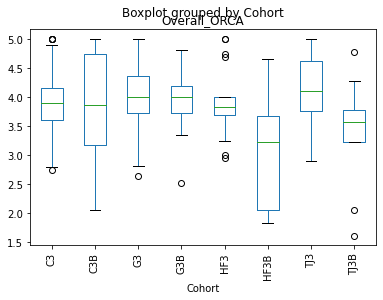

In [39]:
ORCA_df_long.boxplot(column='Overall_ORCA', by='Cohort',rot=90,grid=False)

In [ ]:
ORCA_df_long.groupby(['Cohort'])['Overall_ORCA'].mean()#.plot(kind='box',rot=90)

In [138]:
ORCA_cols = [
    'Overall_ORCA',
    'ORCA_8a',
    'ORCA_8b',
    'ORCA_8c',
    'ORCA_8d',
    'ORCA_8e',
    'ORCA_8f'
]

ORCA_resources_cols = [
    '8f_i_C2',
    '8f_ii_C2',
    '8f_iii_C2',
    '8f_iv_C2'
]

In [11]:
kmf = KaplanMeierFitter()
#df.C2_CT1_Q7 = df.C2_CT1_Q7.astype('int')
barrier = 'Q56_8_C2_CT1'
subGroups = [
    #{'filter':df.C2_CT1_Q7 == 1,'label':'Weekly'},
    #{'filter':df.C2_CT1_Q7 == 2,'label':'Every 2 weeks'},
    #{'filter':df.C2_CT1_Q7 == 3,'label':'Monthly'},
    #{'filter':df.C2_CT1_Q7 == 4,'label':'Every other month'},
    #{'filter':df.C2_CT1_Q7 == 5,'label':'We do not usually meet'}
    
    {'filter':df.C2_CT1_Q7 < 3,'label':'More than once a month'},
    {'filter':df.C2_CT1_Q7 == 3,'label':'Once a month'},
    {'filter':df.C2_CT1_Q7 > 3,'label':'Less than once a month'}
    
    #{'filter':df[barrier] == 1, 'label':'1'},
    #{'filter':df[barrier] > 1, 'label':'>1'}
    #{'filter':df.Q56_3_C2_CT1 == 2, 'label':'2'},
    #{'filter':df.Q56_3_C2_CT1 == 3, 'label':'3'},
    #{'filter':df.Q56_3_C2_CT1 == 4, 'label':'4'}
]
df_temp = df[['days','event',barrier]].copy()
#kmf.fit(df_temp['days'], df_temp['event'],label='Overall')
#a1 = kmf.plot(ci_show=False)
#a1 = kmf.plot_cumulative_density(ci_show=False)
useSubGroups = True
if useSubGroups:
    
    for subgroup in subGroups:
        print(subgroup['label'])
        print(len(df_temp[subgroup['filter']]))
        kmf.fit(df_temp[subgroup['filter']]['days'], df_temp[subgroup['filter']]['event'],label=subgroup['label'])
        if 'a1' in locals():
            a1 = kmf.plot_cumulative_density(ax=a1,ci_show=False)
        else:
            a1 = kmf.plot_cumulative_density(ci_show=False)
        #a1 = kmf.plot(ax=a1,ci_show=False)

More than once a month
5
Once a month
20
Less than once a month
9


In [25]:
df.head()

,Hospital ID_x,Hospital Name,C1_C,WD_C1_C,C2_C,WD_C2_C,C2_O,WD_C2_O,C3_C,C3_O,...,C2_C_PCS,C2_CT1,C2_OT1,C2_CT2,C2_OT2,C2_CT3,C2_OT3,event,date,days
0,6930210,Adventist Health Bakersfield,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2019-09-30,578
1,6211510,Arnot Ogden Medical Center,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-09-30,578
2,6410280,Aultman Hospital,0,0,1,0,1,0,0,0,...,0,1,1,0,0,1,1,1,2018-05-01,61
3,6840030,Avista Adventist Hospital,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,2019-03-20,384
4,6421045,Baptist Health Floyd,0,0,1,0,1,0,0,0,...,1,0,0,1,1,1,1,1,2018-09-01,184


In [9]:
import matplotlib.pyplot as plt
plt.close("all")

In [27]:
len(df)

64

27
Iteration 3: norm_delta = 0.00002, step_size = 0.9500, ll = -61.37887, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 3 iterations.


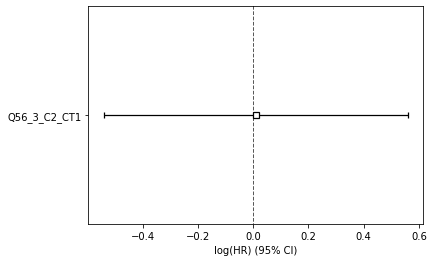

In [9]:
model_cols = [
    #'Hospital Name',
    'event',
    'days'#,
    #'ORCA_Overall'#,
    #'ORCA_8a'#,
    #'ORCA_8b'#,
    #'ORCA_8c'#,
    #'ORCA_8d'#,
    #'ORCA_8e'#,
    #'ORCA_8f'
]
data = df[model_cols+['Q56_3_C2_CT1']].copy()
data.dropna(how='any',inplace=True)
print(len(data))
cph = CoxPHFitter()

cph.fit(data, duration_col='days', event_col='event', show_progress=True)
cph.plot()
#cph.print_summary()

In [20]:
for col in list(barrierCols.keys()):
    #df_barriers[col] = df_barriers[col].astype('int')
    print(df_barriers[col].value_counts())
    print(df_barriers[col].median())

1.0    44
2.0    28
3.0     5
4.0     2
Name: Q56_1_C2_CT1, dtype: int64
1.0
1.0    45
2.0    22
3.0     9
4.0     3
Name: Q56_2_C2_CT1, dtype: int64
1.0
1.0    39
2.0    28
3.0     8
4.0     4
Name: Q56_3_C2_CT1, dtype: int64
2.0
1.0    42
2.0    26
4.0     6
3.0     5
Name: Q56_4_C2_CT1, dtype: int64
1.0
1.0    46
2.0    22
3.0     9
4.0     2
Name: Q56_5_C2_CT1, dtype: int64
1.0
1.0    45
2.0    27
3.0     5
4.0     2
Name: Q56_6_C2_CT1, dtype: int64
1.0
1.0    52
2.0    25
3.0     1
4.0     1
Name: Q56_7_C2_CT1, dtype: int64
1.0
1.0    39
2.0    33
3.0     5
4.0     2
Name: Q56_8_C2_CT1, dtype: int64
2.0
1.0    52
2.0    22
3.0     3
4.0     2
Name: Q56_9_C2_CT1, dtype: int64
1.0
1.0    62
2.0    13
4.0     3
3.0     1
Name: Q56_10_C2_CT1, dtype: int64
1.0
1.0    49
2.0    21
3.0     6
4.0     3
Name: Q56_11_C2_CT1, dtype: int64
1.0
1.0    41
2.0    28
3.0     7
4.0     3
Name: Q56_12_C2_CT1, dtype: int64
1.0
1.0    51
2.0    21
3.0     5
4.0     2
Name: Q56_13_C2_CT1, dtype: int64

Below is HQI analysis notes. Original version consisted of these criteria:

Just a reminder that in order to achieve high quality implementer status on a check-in, teams had to meet the following criteria:
    Share process data at least monthly
    Share outcome data at least quarterly
    Meet as a team at least monthly
    Senior executive sponsor attends meetings:
        4/8 month surveys: Most of the time, some of time, or half of the time
        12 month: At least 50% of the time